<a href="https://colab.research.google.com/github/OracyC/TMDB-Box-Office-Prediction/blob/master/TMDB_Box_Office_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data



In [69]:
files = "https://github.com/OracyC/TMDB-Box-Office-Prediction/raw/master/tmdb-box-office-prediction.zip" 
!rm -rf * && pip install git+https://github.com/data-8/Gofer-Grader && wget $files && unzip -o tmdb-box-office-prediction.zip

  Cloning https://github.com/data-8/Gofer-Grader to /tmp/pip-req-build-jly3ixby
  Running command git clone -q https://github.com/data-8/Gofer-Grader /tmp/pip-req-build-jly3ixby
  Created wheel for gofer-grader: filename=gofer_grader-1.0.9-cp36-none-any.whl size=10169 sha256=5cd42f10acb201a6f7009e40fd93094eef8a4e7f18013eec65d27a0116638cc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yoyroyk/wheels/9e/62/24/8563ae039051d6ba979557d1766bfebbda5dd08f8572e3e35d
Successfully built gofer-grader
--2019-11-30 19:18:07--  https://github.com/OracyC/TMDB-Box-Office-Prediction/raw/master/tmdb-box-office-prediction.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/OracyC/TMDB-Box-Office-Prediction/master/tmdb-box-office-prediction.zip [following]
--2019-11-30 19:18:07--  https://raw.githubusercontent.com/OracyC/TMDB-Box-Office-P

In [0]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA & Feature Engerineering

In [71]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [72]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [73]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [74]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [75]:
train.describe(include=['O'])

,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,Keywords,cast,crew
count,604,2993,946,3000,3000,3000,2992,2999,2844,2945,3000,2980,3000,2403,3000,2724,2987,2984
unique,422,872,941,3000,36,2975,2992,2999,2383,321,2398,401,2,2400,2969,2648,2975,2984
top,"[{'id': 645, 'name': 'James Bond Collection', ...","[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1341167,en,Priest,"Paul Snider is a narcissistic, small time hust...",/hvbhwHicdlmRtzAQsZH9aabpIBn.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Ben-Hur,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '52fe4515c3a36847f80bb925', 'de..."
freq,16,266,4,1,2575,2,1,1,51,1752,5,1817,2996,3,2,27,13,1


## Feaature Engineering

In [0]:
def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''

def proc_json_len(string):
    try:
        data = eval(string)
        return len(data)
    except:
        return 0

    
def feature_engineering(df):
    # fill out missing values
    df.runtime.fillna(0, inplace=True)
    df.status.fillna('Released', inplace=True)
    df.release_date.fillna(df.release_date.mode()[0], inplace=True)

    # create count features
    df['count_genre'] = df.genres.apply(proc_json_len)
    df['count_country'] = df.production_countries.apply(proc_json_len)
    df['count_company'] = df.production_companies.apply(proc_json_len)
    df['count_splang'] = df.spoken_languages.apply(proc_json_len)
    df['count_cast'] = df.cast.apply(proc_json_len)
    df['count_crew'] = df.crew.apply(proc_json_len)
    df['count_staff'] = df.count_cast + df.count_crew
    df['count_keyword'] = df.Keywords.apply(proc_json_len)
    
    # convert json features
    df.belongs_to_collection = df.belongs_to_collection.apply(lambda x: proc_json(x, 'name'))
    df.genres = df.genres.apply(lambda x: proc_json(x, 'name'))
    df.production_companies = df.production_companies.apply(lambda x: proc_json(x, 'name'))
    df.production_countries = df.production_countries.apply(lambda x: proc_json(x, 'iso_3166_1'))
    df.spoken_languages = df.spoken_languages.apply(lambda x: proc_json(x, 'iso_639_1'))
    df.Keywords = df.Keywords.apply(lambda x: proc_json(x, 'name'))
    
    # create length of text features
    df['len_title'] = df.title.str.len()
    df.len_title.fillna(0, inplace=True)
    df['len_overview'] = df.overview.str.len()
    df.len_overview.fillna(0, inplace=True)
    df['len_tagline'] = df.tagline.str.len()
    df.len_tagline.fillna(0, inplace=True)
    
    # create date related features
    df.release_date = pd.to_datetime(df.release_date)
    df['release_year'] = df.release_date.dt.year
    df['release_year'] = df.release_year.apply(lambda x: x-100 if x > 2020 else x)
    df['release_month'] = df.release_date.dt.month
    df['release_wday'] = df.release_date.dt.dayofweek

    # create boolean features
    df['in_collection'] = (df.belongs_to_collection != '').astype('uint8')
    df['us_country'] = df.production_countries.str.contains('US').astype('uint8')
    df['en_lang'] = (df.original_language == 'en').astype('uint8')
    df['has_hompage'] = df.homepage.apply(lambda x: 1 if pd.isnull(x) == False else 0)

    # log money values
    if 'revenue' in df.columns:
        df.revenue = np.log1p(df.revenue)
    df.budget = np.log1p(df.budget)
    df.popularity = np.log1p(df.popularity)
    
    return df

In [0]:
train = feature_engineering(train)
test = feature_engineering(test)

## EDA

In [78]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,len_title,len_overview,len_tagline,release_year,release_month,release_wday,in_collection,us_country,en_lang,has_hompage
0,1,Hot Tub Time Machine Collection,16.454568,Comedy,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"Paramount Pictures,United Artists,Metro-Goldwy...",US,2015-02-20,93.0,en,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"time travel,sequel,hot tub,duringcreditsstinger","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.326300,1,1,3,1,24,72,96,4,22,155.0,52.0,2015,2,4,1,1,1,0
1,2,The Princess Diaries Collection,17.504390,"Comedy,Drama,Family,Romance",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,Walt Disney Pictures,US,2004-08-06,113.0,en,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"coronation,duty,marriage,falling in love","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",18.370959,4,1,1,1,20,9,29,4,40,393.0,60.0,2004,8,4,1,1,1,0
2,3,,15.009433,Drama,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"Bold Films,Blumhouse Productions,Right of Way ...",US,2014-10-10,105.0,en,Released,The road to greatness can take you to the edge.,Whiplash,"jazz,obsession,conservatory,music teacher,new ...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",16.387512,1,1,3,1,51,64,115,12,8,130.0,47.0,2014,10,4,0,1,1,1
3,4,,13.997833,"Thriller,Drama",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,,IN,2012-03-09,122.0,"en,hi",Released,NaN,Kahaani,"mystery,bollywood,police corruption,crime,indi...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16.588099,2,1,0,2,7,3,10,7,7,581.0,0.0,2012,3,4,0,0,0,1
4,5,,0.000000,"Action,Thriller",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,,KR,2009-02-05,118.0,ko,Released,NaN,Marine Boy,,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",15.182615,2,1,0,1,4,2,6,0,10,168.0,0.0,2009,2,3,0,0,0,0


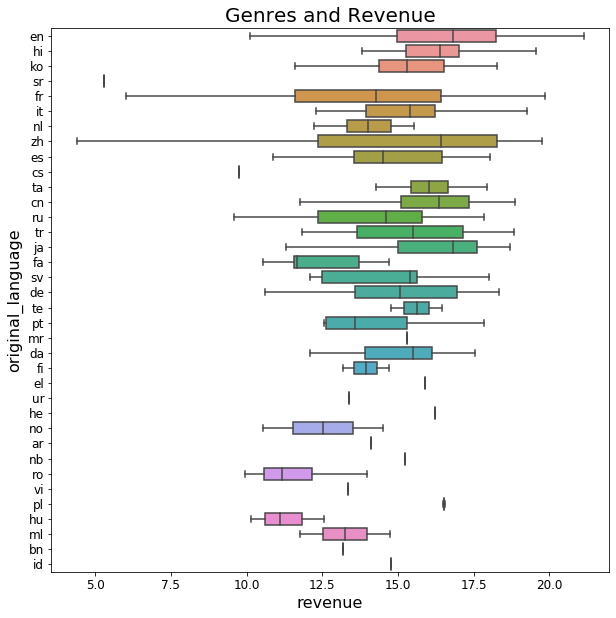

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', labelsize=12)
plt.title('Genres and Revenue', fontsize=20)
plt.xlabel('revenue', fontsize=16)
plt.ylabel('genre', fontsize=16)
sns.boxplot(ax=ax, x=train['revenue'], y=train['original_language'],showfliers=False)
plt.show()

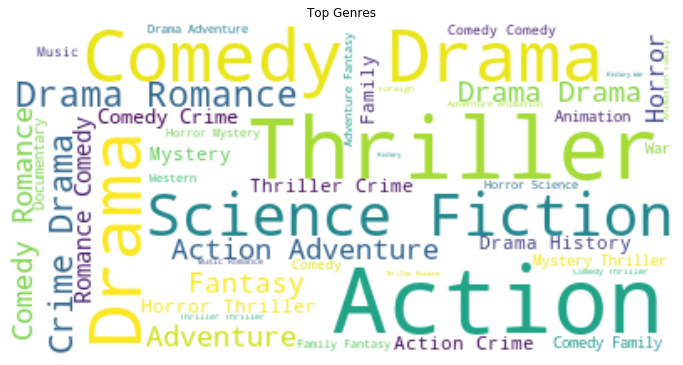

In [80]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=55, max_words=100, background_color="white").generate(train['genres'].to_string())
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Top Genres")
plt.axis("off")
plt.show()

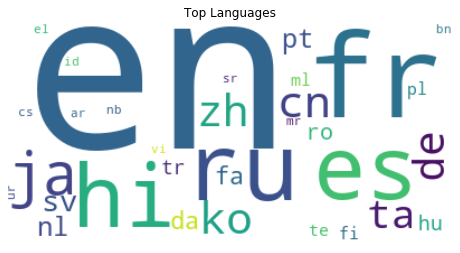

In [81]:
wordcloud1 = WordCloud(max_font_size=200, max_words=100, background_color="white").generate(train['original_language'].to_string())
plt.figure(figsize = (8, 7))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.title("Top Languages")
plt.axis("off")
plt.show()

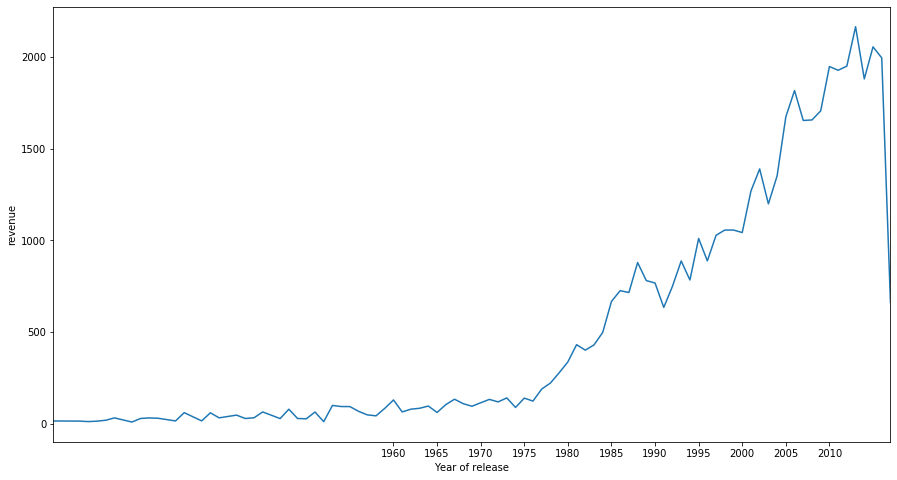

In [82]:
year_plot = train[['revenue', 'release_year']]
money_Y = year_plot.groupby('release_year')['revenue'].sum()

money_Y.plot(figsize=(15,8))
plt.xlabel("Year of release")
plt.ylabel("revenue")
plt.xticks(np.arange(1960,2015,5))

plt.show()

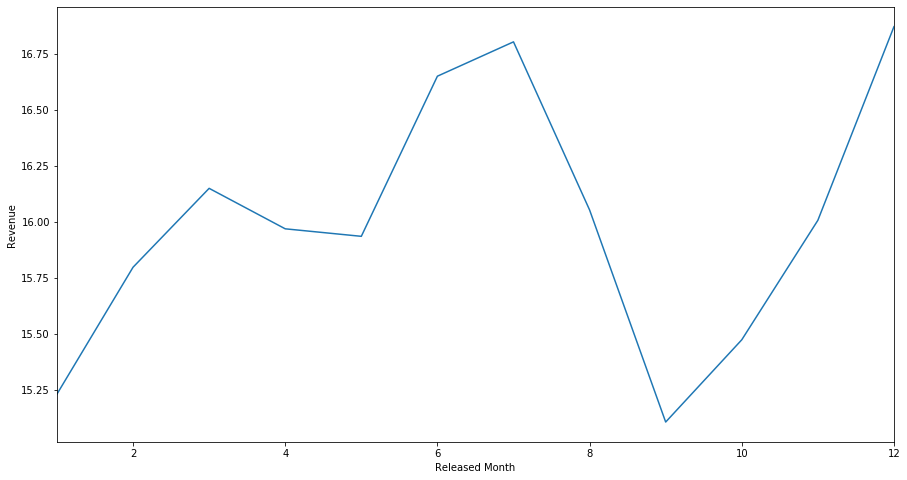

In [83]:
month_plot = train[['revenue', 'release_month']]
money_M = month_plot.groupby('release_month')['revenue'].mean()

money_M.plot(figsize=(15,8))
plt.xlabel("Released Month")
plt.ylabel("Revenue")

plt.show()

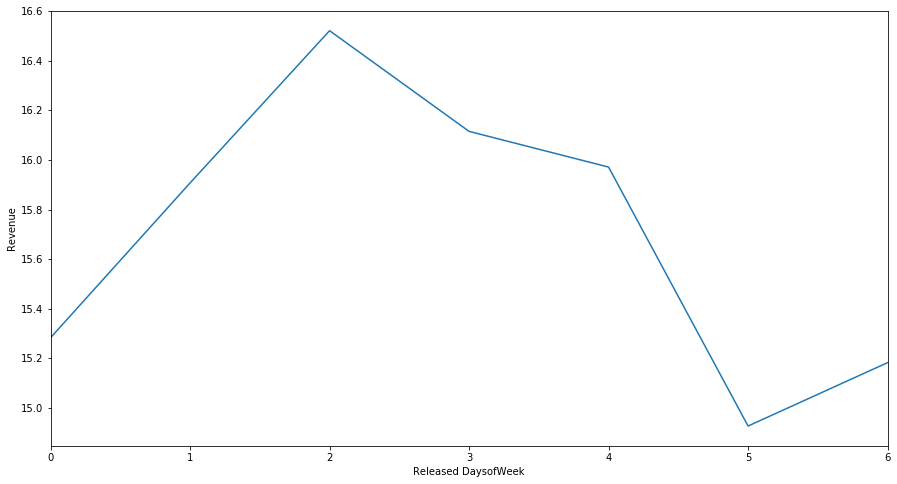

In [84]:
wday_plot = train[['revenue', 'release_wday']]
money_W = wday_plot.groupby('release_wday')['revenue'].mean()

money_W.plot(figsize=(15,8))
plt.xlabel("Released DaysofWeek")
plt.ylabel("Revenue")

plt.show()

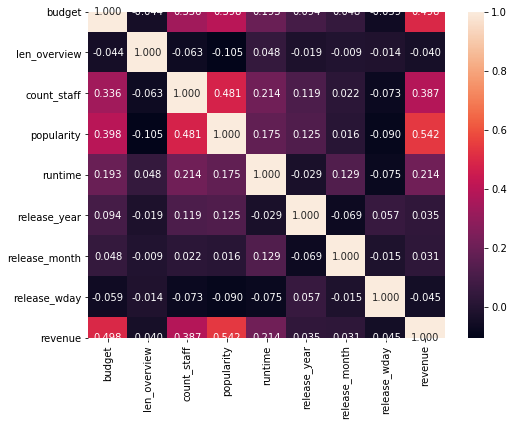

In [85]:
cor_features = train[['budget', 'len_overview', 'count_staff', 'popularity', 'runtime',
            'release_year', 'release_month', 'release_wday','revenue']]
f,ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cor_features.corr(), annot=True, linewidths=0, fmt= '.3f',ax=ax)
plt.show()

## Data preparation

In [0]:
#prepare data for training
train_new = train.drop(columns=['id','belongs_to_collection','genres','homepage','imdb_id','original_language'
                ,'original_title','overview','poster_path','production_companies','production_countries'
                ,'release_date','spoken_languages','status','tagline','title','Keywords','cast','crew'])

In [87]:
from sklearn.model_selection  import train_test_split

y = train_new.revenue

X = train_new.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2100, 21) (900, 21) (2100,) (900,)


In [88]:
X_train.head()

,budget,popularity,runtime,count_genre,count_country,count_company,count_splang,count_cast,count_crew,count_staff,count_keyword,len_title,len_overview,len_tagline,release_year,release_month,release_wday,in_collection,us_country,en_lang,has_hompage
1732,15.520259,0.811060,140.0,3,1,1,1,10,1,11,0,11,478.0,23.0,2013,9,4,1,0,0,0
2440,17.111347,2.497405,110.0,4,2,6,1,17,16,33,18,19,284.0,38.0,2006,2,4,0,1,1,0
1232,0.000000,0.481459,116.0,1,2,7,1,7,14,21,2,15,393.0,0.0,2007,9,2,0,0,1,1
1081,16.523561,2.652101,110.0,5,1,2,1,19,13,32,10,13,373.0,80.0,1987,3,4,1,1,1,0
2920,0.000000,0.041176,92.0,3,2,4,1,38,31,69,5,14,490.0,41.0,2000,10,6,0,0,1,0


# Modeling

In [0]:
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# print_score function depending on the evaluation metric: rmse
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=99)
forest.fit(X_train, y_train) 
importances = forest.feature_importances_
forest1 = RandomForestRegressor(random_state=99)
forest1.fit(X_test, y_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=99, verbose=0,
                      warm_start=False)

In [91]:
print('R2 for Train)', forest.score( X_train, y_train ))
print('R2 for Test (cross validation)', forest1.score(X_test, y_test))
print_score(forest)
print_score(forest1)

R2 for Train) 0.897723988403196
R2 for Test (cross validation) 0.8904317688503717
[0.9932445568858738, 2.2078277190986983, 0.897723988403196, 0.4385395381074947]
[2.3508134101743043, 0.9753217686381535, 0.4270750768034139, 0.8904317688503717]


## Linear Regression

In [92]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit( X_train, y_train )
print('R2 for Train', lm.score( X_train, y_train ))
print('R2 for Test (cross validation)', lm.score(X_test, y_test))
print_score(lm)

R2 for Train 0.4467076347863959
R2 for Test (cross validation) 0.3895719614350762
[2.3101843668092945, 2.3020928135706282, 0.4467076347863959, 0.3895719614350762]


## LightGBM

In [0]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=650,
                              max_bin=58, bagging_fraction=0.80,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=7, min_sum_hessian_in_leaf=11)


In [100]:
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=10)
lgbm_train_y = lgbm.predict(X_train)
lgbm_test_y = np.expm1(lgbm.predict(X_train))
print_score(lgbm)

[1]	valid_0's l1: 2.19422	valid_0's l2: 8.56356
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 2.18408	valid_0's l2: 8.49921
[3]	valid_0's l1: 2.167	valid_0's l2: 8.37033
[4]	valid_0's l1: 2.14391	valid_0's l2: 8.22122
[5]	valid_0's l1: 2.11088	valid_0's l2: 7.99578
[6]	valid_0's l1: 2.08101	valid_0's l2: 7.79919
[7]	valid_0's l1: 2.07246	valid_0's l2: 7.73499
[8]	valid_0's l1: 2.05727	valid_0's l2: 7.63318
[9]	valid_0's l1: 2.03171	valid_0's l2: 7.469
[10]	valid_0's l1: 1.99383	valid_0's l2: 7.22689
[11]	valid_0's l1: 1.98111	valid_0's l2: 7.14195
[12]	valid_0's l1: 1.96885	valid_0's l2: 7.07286
[13]	valid_0's l1: 1.94777	valid_0's l2: 6.94054
[14]	valid_0's l1: 1.93495	valid_0's l2: 6.86124
[15]	valid_0's l1: 1.90162	valid_0's l2: 6.66509
[16]	valid_0's l1: 1.88376	valid_0's l2: 6.55829
[17]	valid_0's l1: 1.87083	valid_0's l2: 6.49494
[18]	valid_0's l1: 1.85958	valid_0's l2: 6.43624
[19]	valid_0's l1: 1.85006	valid_0's l2: 6.38821
[20]	valid_0's l1: 1

## Prepare Submission

In [0]:
#prepare data for submission
test_new = test.drop(columns=['id','belongs_to_collection','genres','homepage','imdb_id','original_language'
                ,'original_title','overview','poster_path','production_companies','production_countries'
                ,'release_date','spoken_languages','status','tagline','title','Keywords','cast','crew'])
predictions = np.expm1(lgbm.predict(test_new))

In [104]:
sub = pd.read_csv('sample_submission.csv')
sub['revenue'] = np.round(predictions)
sub.head()

,id,revenue
0,3001,709274.0
1,3002,1349615.0
2,3003,3839504.0
3,3004,19448271.0
4,3005,487926.0


In [0]:
sub.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')